# Brain Tumor Detection
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/brain-tumor-detection'

In [2]:
from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU'), tf.__version__

2025-03-26 07:48:26.987924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742975307.058328   28500 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742975307.078843   28500 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742975307.247560   28500 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742975307.247581   28500 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742975307.247583   28500 computation_placer.cc:177] computation placer alr

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.19.0')

In [3]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

In [4]:
from src.utils.visualization_funcs import plot_random_images_bbox
from src.losses.binary_weighted_loss import  set_binary_crossentropy_weighted_loss

## Paths Setup

In [5]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/-Brain-Tumor-Detection-2/train/


In [6]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [7]:
from pathlib import Path

DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)

MODEL_CHECKPOINT = Path(cfg.OUTPUTS.CHECKPOINT_PATH)
OUTPUT_DIR = Path(cfg.OUTPUTS.OUTPUT_DIR)
IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE

CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {v: k for k, v in enumerate(CLASS_NAME)}
class_map[CLASS_NAME[0]]

0

## Dataset Download from Roboflow

## Load images from directory

In [8]:
from src.data_handler.preprocessor import Preprocessor
from src.data_handler.annotation_processor import AnnotationProcessor
from src.data_handler.data_loader import DataLoader

_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
prepare_test_dataset = AnnotationProcessor(annotation_file= str(TEST_DIR/'_annotations.csv'))
test_image_paths, test_class_ids, test_bboxes  = prepare_test_dataset.process_annotations(image_dir=TEST_DIR, class_id_map=_class_map)
test_dl = DataLoader(test_image_paths, test_class_ids, test_bboxes, img_size=IMG_SIZE)
test_ds = test_dl.load_val_dataset()
y_true_labels = test_dl.multi_hot_class_ids
y_true_bboxes = test_dl.padded_bbx
test_ds = Preprocessor(test_ds).preprocess()
test_ds = test_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

I0000 00:00:1742975316.484973   28500 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7540 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [9]:
for batch in test_ds.take(1):
    print(batch[0].shape, batch[1][0].shape, batch[1][1].shape)
    print(batch[1][0][0])
    print(batch[1][1][0])

(64, 240, 240, 3) (64, 3) (64, 3, 4)
tf.Tensor([1. 1. 1.], shape=(3,), dtype=float32)
tf.Tensor(
[[0.6115108  0.65909094 0.7553957  0.82575756]
 [0.36690646 0.5833333  0.8561151  0.9848485 ]
 [0.58992803 0.6666667  0.78417265 0.84090906]], shape=(3, 4), dtype=float32)


2025-03-26 07:48:36.905040: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Load the model

In [10]:
import mlflow
import keras


# model_uri = 'runs:/3b5d4a72619f4e5d9085ccdcabc16c6a/model'
# loaded_model = mlflow.tensorflow.load_model(model_uri)
loaded_model = keras.models.load_model('output/checkpoints/detector_ckpt_125.keras',
                                       compile=False # Do not re-compile the model because using it for inference only
)

# Verify the model with the provided input data using the logged dependencies.
# For more details, refer to:
# https://mlflow.org/docs/latest/models.html#validate-models-before-deployment
# mlflow.models.predict(
#     model_uri=model_uri,
#     input_data=input_data,
#     env_manager="uv",
# )

In [11]:
test_bboxes[:5]

[array([[0.61151079, 0.65909091, 0.75539568, 0.82575758],
        [0.36690647, 0.58333333, 0.85611511, 0.98484848],
        [0.58992806, 0.66666667, 0.78417266, 0.84090909]]),
 array([[0.61151079, 0.09848485, 0.99280576, 0.4469697 ]]),
 array([[0.23021583, 0.53787879, 0.70503597, 0.97727273],
        [0.1942446 , 0.41666667, 0.97841727, 0.97727273],
        [0.28057554, 0.58333333, 0.55395683, 0.86363636]]),
 array([[0.54676259, 0.04545455, 0.84892086, 0.39393939],
        [0.65467626, 0.24242424, 0.89928058, 0.35606061],
        [0.55395683, 0.0530303 , 0.85611511, 0.39393939]]),
 array([[0.20863309, 0.64393939, 0.60431655, 0.84848485],
        [0.22302158, 0.68181818, 0.26618705, 0.74242424]])]

In [12]:
unnorm_y_true_bbx = [bbx*IMG_SIZE for bbx in test_bboxes]

In [13]:
import random

def plot_random_images_bbox(random_samples:np.ndarray, image_paths:np.ndarray, class_ids:np.ndarray, bboxes:np.ndarray, class_map:dict) -> None:
  fig = plt.figure(figsize=(8, 8))

  print(f"Random samples: {random_samples}")
  class_map_invert = {v: k for k, v in class_map.items()}
  
  for i, idx in enumerate(random_samples):
    ax = fig.add_subplot(3, 3, i+1)
    image = image_paths[idx]
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    # Create title from class IDs
    title_labels = [class_map_invert[int(cls_id)] for cls_id in class_ids[idx]]
    title = ", ".join(title_labels)
    ax.set_title(title)
    # ax.imshow(image) #display image before bounding box

    # Draw bounding boxes with different colors
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0,255,255), (255,0,255)] # Example colors
    for j, (xmin, ymin, xmax, ymax) in enumerate(bboxes[idx]):
        color = colors[j % len(colors)] # Cycle through colors
        cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 1)
    ax.imshow(image) #display image with bounding box.

  plt.tight_layout() #prevents overlapping subplots
  plt.show()

Random samples: [35, 920, 119, 581, 587, 658, 300, 227, 192]


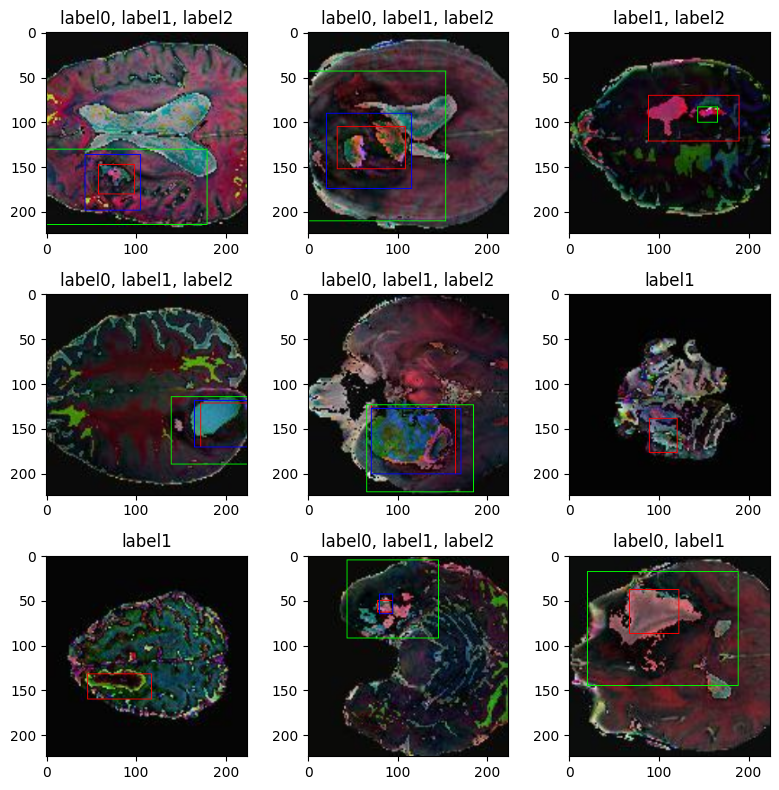

In [14]:
random_samples = random.sample(range(len(test_image_paths)), 9)
# random_samples = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# xmin,ymin,xmax,ymax
plot_random_images_bbox(random_samples=random_samples,
                        image_paths=test_image_paths, 
                        class_ids=test_class_ids, 
                        bboxes=unnorm_y_true_bbx,
                        class_map=class_map)

In [15]:
y_prob_pred, pred_bbx = loaded_model.predict(test_ds)
y_prob_pred[0], '------------------------------------' ,pred_bbx[0]

I0000 00:00:1742975324.397686   28735 service.cc:152] XLA service 0x750fa4003b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742975324.397704   28735 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-26 07:48:44.531175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742975325.288278   28735 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

I0000 00:00:1742975329.000034   28735 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 360ms/step


(array([0.9883, 0.679 , 0.99  ], dtype=float16),
 '------------------------------------',
 array([[0.609 , 0.6836, 0.7817, 0.8413],
        [0.3699, 0.62  , 0.872 , 0.934 ],
        [0.5947, 0.6743, 0.7896, 0.8555]], dtype=float16))

In [16]:
y_pred = (y_prob_pred>0.5).astype(int)
y_pred[:5]

array([[1, 1, 1],
       [0, 1, 0],
       [1, 1, 1],
       [1, 1, 1],
       [0, 1, 0]])

In [17]:
from sklearn.metrics import classification_report


report = classification_report(y_true_labels, y_pred, labels=[0,1,2], target_names=CLASS_NAME)
print(report)

              precision    recall  f1-score   support

      label0       0.94      0.85      0.90       588
      label1       1.00      0.89      0.94       962
      label2       0.95      0.78      0.86       554

   micro avg       0.97      0.85      0.91      2104
   macro avg       0.96      0.84      0.90      2104
weighted avg       0.97      0.85      0.91      2104
 samples avg       0.89      0.83      0.84      2104



/code/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
unnorm_y_pred_bbx = []
for bbx in pred_bbx:
   unnorm_y_pred_bbx.append(bbx*IMG_SIZE)

In [19]:
y_pred = (y_prob_pred>0.5).astype(int)
y_pred[:5]

array([[1, 1, 1],
       [0, 1, 0],
       [1, 1, 1],
       [1, 1, 1],
       [0, 1, 0]])

In [20]:
# Convert class IDs to class names
pred_cls = [np.where(row==1)[0].tolist() for row in y_pred]
pred_cls[:5]

[[0, 1, 2], [1], [0, 1, 2], [0, 1, 2], [1]]

In [21]:
for idx in random_samples:
   print([cls_id for cls_id in pred_cls[idx]])

[0, 1, 2]
[0, 1, 2]
[]
[0, 1, 2]
[0, 1, 2]
[1]
[]
[0, 1, 2]
[0, 1]


Random samples: [35, 920, 119, 581, 587, 658, 300, 227, 192]


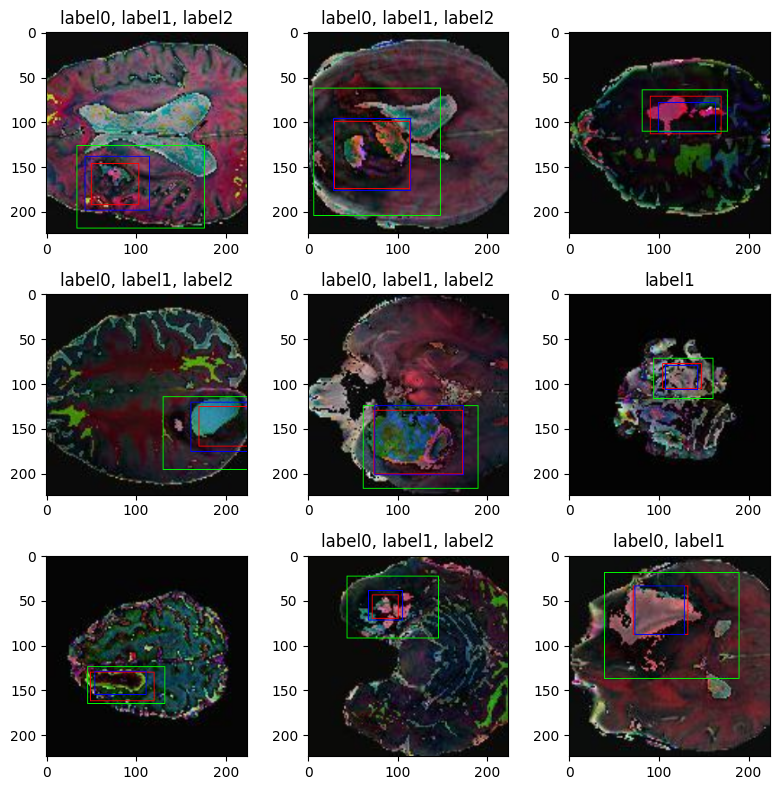

In [22]:
plot_random_images_bbox(random_samples=random_samples,
                        image_paths=test_image_paths, 
                        class_ids=pred_cls, 
                        bboxes=unnorm_y_pred_bbx,
                        class_map=class_map)

In [23]:
test_bboxes[:2], pred_bbx[:2]

([array([[0.61151079, 0.65909091, 0.75539568, 0.82575758],
         [0.36690647, 0.58333333, 0.85611511, 0.98484848],
         [0.58992806, 0.66666667, 0.78417266, 0.84090909]]),
  array([[0.61151079, 0.09848485, 0.99280576, 0.4469697 ]])],
 array([[[0.609 , 0.6836, 0.7817, 0.8413],
         [0.3699, 0.62  , 0.872 , 0.934 ],
         [0.5947, 0.6743, 0.7896, 0.8555]],
 
        [[0.6274, 0.1394, 0.9385, 0.446 ],
         [0.644 , 0.1537, 0.943 , 0.4688],
         [0.691 , 0.1624, 0.922 , 0.4067]]], dtype=float16))

In [24]:
unnorm_y_true_bbx[:1], unnorm_y_pred_bbx[:1]

([array([[146.76258993, 158.18181818, 181.29496403, 198.18181818],
         [ 88.05755396, 140.        , 205.4676259 , 236.36363636],
         [141.58273381, 160.        , 188.20143885, 201.81818182]])],
 [array([[146.1 , 164.  , 187.6 , 201.9 ],
         [ 88.75, 148.9 , 209.2 , 224.1 ],
         [142.8 , 161.9 , 189.5 , 205.2 ]], dtype=float16)])

### Plot AUC curve

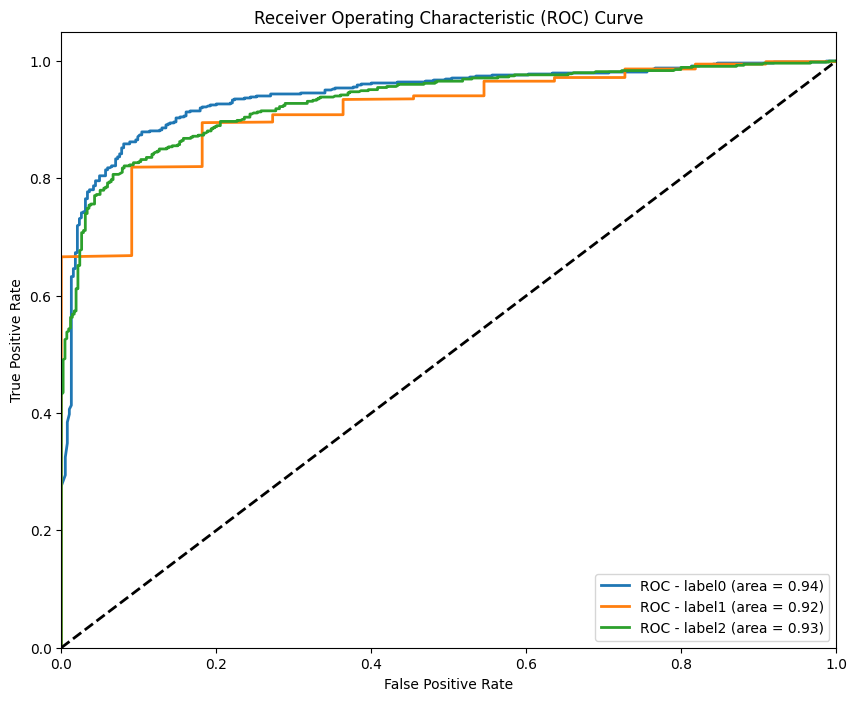

In [25]:
from src.utils.visualization_funcs import plot_auc_curve

plot_auc_curve(OUTPUT_DIR, CLASS_NAME, y_true_labels, y_prob_pred)

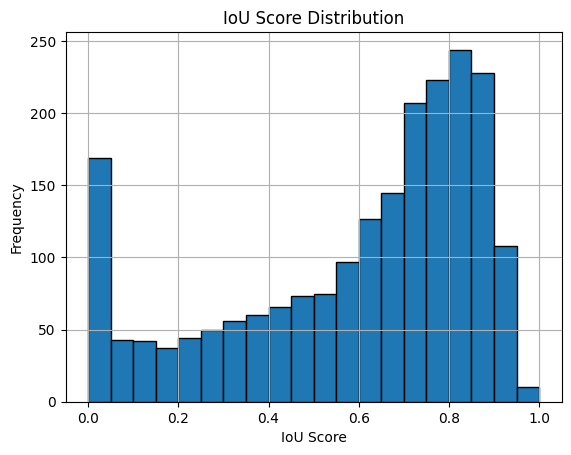

<Figure size 640x480 with 0 Axes>

In [26]:
from src.utils.visualization_funcs import plot_iou_histogram


fig = plot_iou_histogram(OUTPUT_DIR, y_true_bboxes, pred_bbx, pred_bbx)

In [27]:

def plot_random_images_bbox(random_samples:np.ndarray, image_paths:np.ndarray, class_ids:np.ndarray, bboxes:np.ndarray, class_map:dict) -> None:
  fig = plt.figure(figsize=(8, 8))

  print(f"Random samples: {random_samples}")
  class_map_invert = {v: k for k, v in class_map.items()}
  
  for i, idx in enumerate(random_samples):
    ax = fig.add_subplot(3, 3, i+1)
    image = image_paths[idx]
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    # Create title from class IDs
    title_labels = [class_map_invert[int(cls_id)] for cls_id in class_ids[idx]]
    title = ", ".join(title_labels)
    ax.set_title(title)
    # ax.imshow(image) #display image before bounding box

    # Draw bounding boxes with different colors
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0,255,255), (255,0,255)] # Example colors
    for j, (xmin, ymin, xmax, ymax) in enumerate(bboxes[idx]):
        color = colors[j % len(colors)] # Cycle through colors
        cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 1)
    ax.imshow(image) #display image with bounding box.

  plt.tight_layout() #prevents overlapping subplots
  plt.show()

In [56]:
def plot_predictions_vs_ground_truth_from_arrays(
    image_paths: np.ndarray,
    pred_class_ids: np.ndarray,
    pred_bboxes: np.ndarray,
    gt_class_ids: np.ndarray,
    gt_bboxes: np.ndarray,
    class_map: dict,
) -> None:

    random_samples = random.sample(range(len(test_image_paths)), 8)
    num_images = len(random_samples)

    fig, axes = plt.subplots(num_images, 2, figsize=(12, 4 * num_images))
    class_map_invert = {v: k for k, v in class_map.items()}

    for i in range(num_images):
        # --- Plot Predictions ---
        ax_pred = axes[i, 0]
        idx_pred = random_samples[i]
        image = cv2.imread(image_paths[idx_pred])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        gt_img = image.copy()

        # Draw predicted bounding boxes
        colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
        
        # --- Plot Ground Truth ---
        ax_gt = axes[i, 1]
        idx_gt = random_samples[i]
        title_labels_gt = [class_map_invert[int(cls_id)] for cls_id in gt_class_ids[idx_gt]]

        title_gt = ", ".join(title_labels_gt)
        ax_gt.set_title(f"Ground Truth: {title_gt}")

        # Draw ground truth bounding boxes
        for j, (xmin, ymin, xmax, ymax) in enumerate(gt_bboxes[idx_gt]):
            
            color = colors[j]
            cv2.rectangle(gt_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 1)
        ax_gt.imshow(gt_img)

        title_labels_pred = [class_map_invert[int(cls_id)] for cls_id in pred_class_ids[idx_pred]]
        title_pred = ", ".join(title_labels_pred)
        for j, (xmin, ymin, xmax, ymax) in enumerate(pred_bboxes[idx_pred]):
            if j < len(title_labels_pred):
                color = colors[j]
                cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 1)

        ax_pred.imshow(image)
        if not title_pred:
            title_pred = "No Labels Found"
        ax_pred.set_title(f"Predictions: {title_pred}")

    plt.tight_layout()
    plt.show()

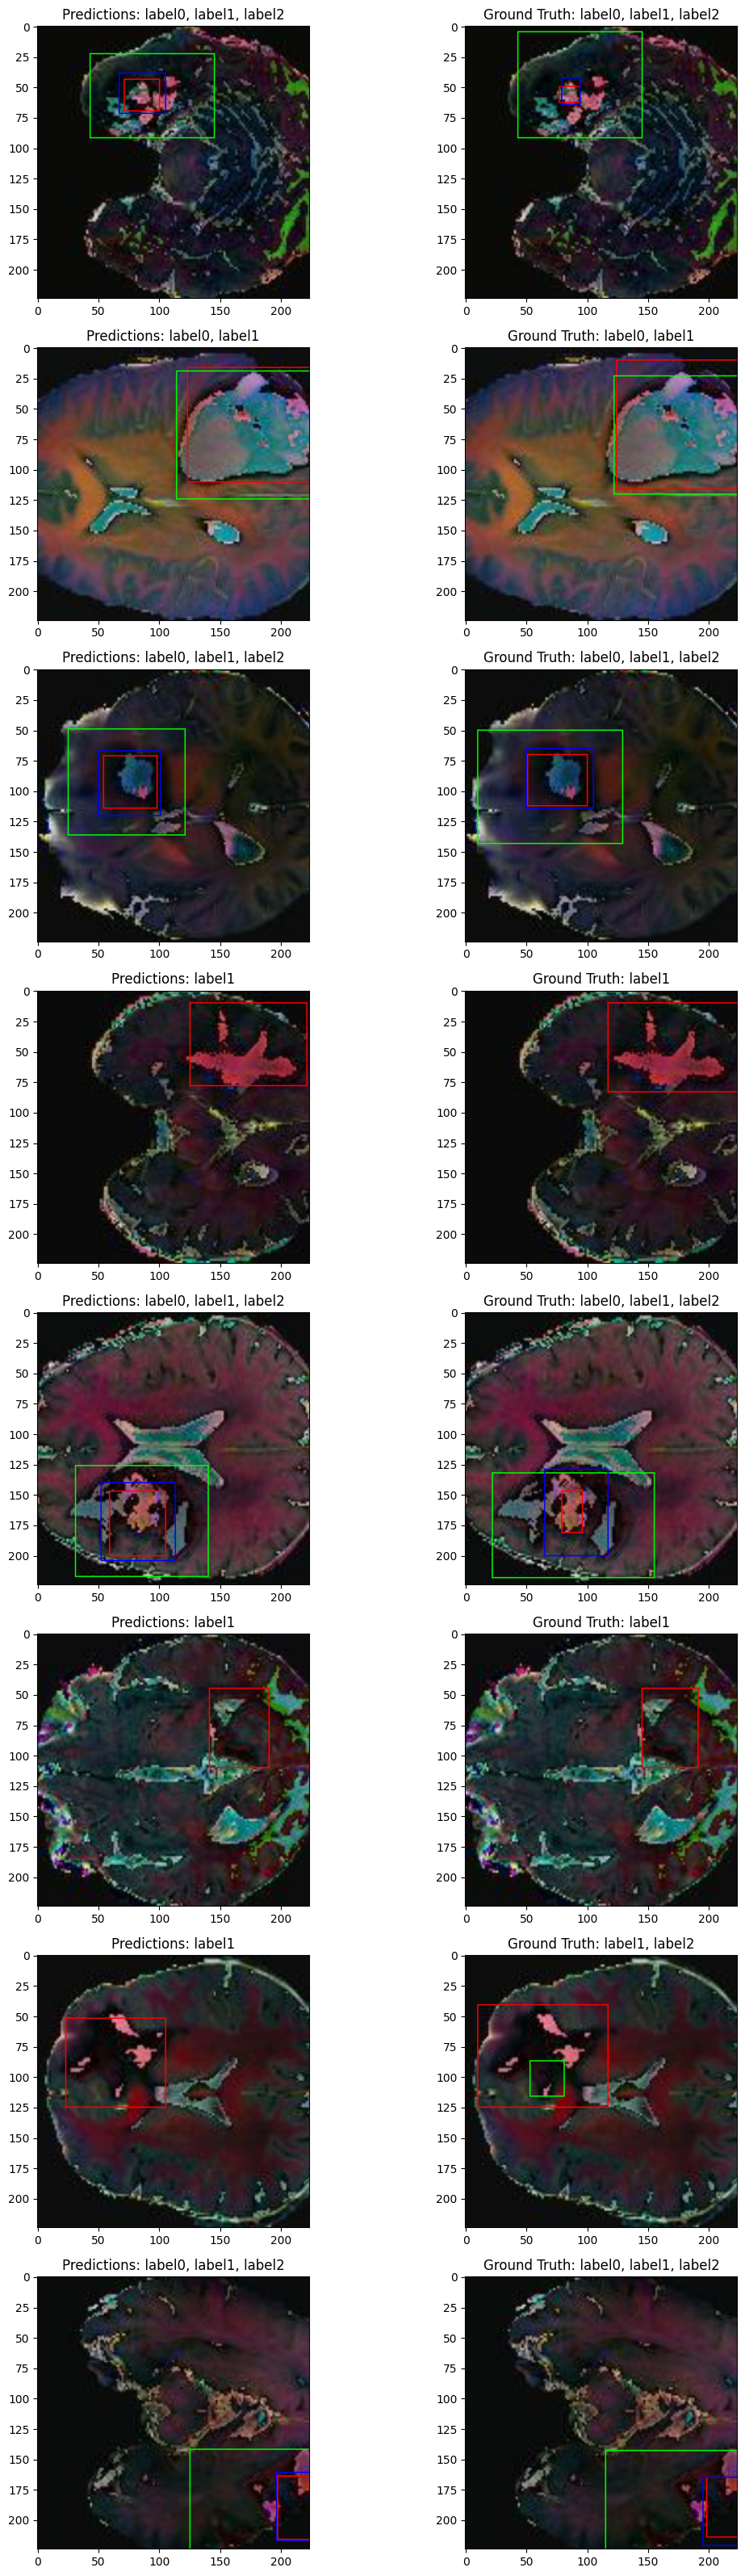

In [57]:
plot_predictions_vs_ground_truth_from_arrays(
    image_paths=test_image_paths,
    pred_class_ids=pred_cls,
    pred_bboxes=unnorm_y_pred_bbx,
    gt_class_ids=test_class_ids,
    gt_bboxes=unnorm_y_true_bbx,
    class_map=class_map,
)

In [ ]:
plot_random_images_bbox(random_samples=random_samples,
                        image_paths=test_image_paths, 
                        class_ids=test_class_ids, 
                        bboxes=unnorm_y_true_bbx,
                        class_map=class_map)